In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'


In [116]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, \
                             RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, \
                            recall_score, roc_auc_score, roc_curve, classification_report
import classifier_utils as cu

from scipy.stats import zscore

In [170]:
sns.set_context('talk')

In [117]:
data = pd.read_csv('data/cleaned_data_more_feats.csv', index_col = 0)

In [118]:
train_df, test_df = train_test_split(data, test_size = .25)
all_feats = data.columns[5:-3]
best_feats =['period','impact_parameter','transit_duration','transit_depth','radius','inclination',
             'mse_stat','mme_stat','signal_to_noise','num_transits','oedc_stat','stellar_eff_temp',
             'stellar_surf_grav','stellar_metal','stellar_radius','stellar_mass']

## Baseline model performance

In [119]:
model = xgb.XGBClassifier(n_estimators=50000,max_depth = 6,eta = 0.025,objective='binary:logistic',
                          min_child_weight=1,subsample = 1,colsample_bytree=.8,use_label_encoder=False)

In [67]:
cu.xgb_test_model_CV(model, train_df, best_feats)

Mean validation accuracy: 0.880
Mean validation recall  : 0.918
Mean validation precision: 0.859
Mean validation f1  : 0.887
Mean validation roc_auc: 0.944


                 precision    recall  f1-score   support

Not a Candidate       0.92      0.86      0.89       744
      Candidate       0.87      0.93      0.90       754

       accuracy                           0.89      1498
      macro avg       0.90      0.89      0.89      1498
   weighted avg       0.90      0.89      0.89      1498



<Figure size 900x600 with 0 Axes>

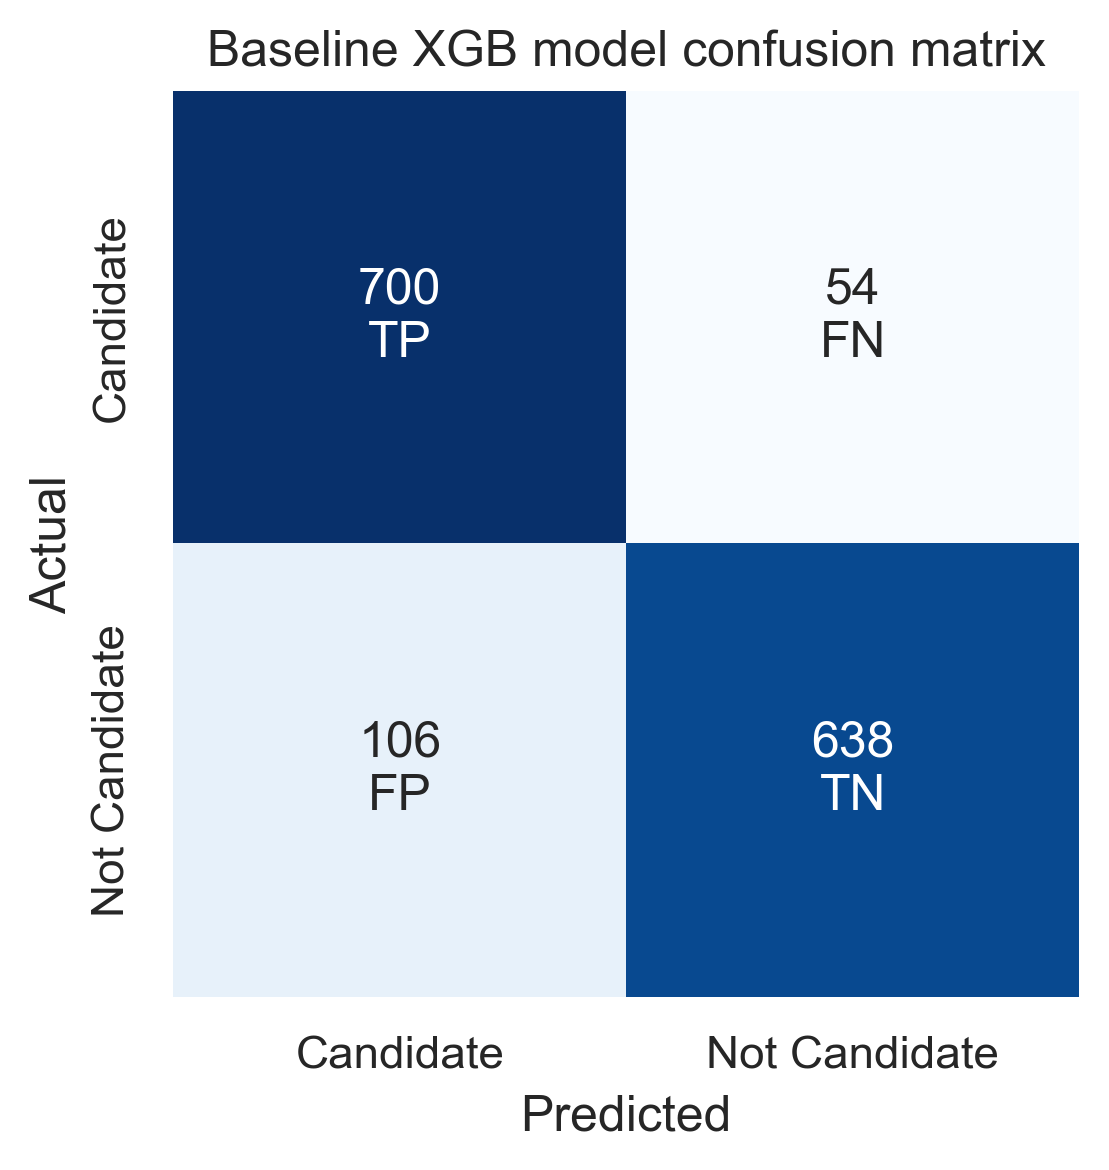

In [61]:
cu.plot_confusion_matrix(model, train_df, best_feats, title='Baseline XGB model')

ROC AUC score =  0.9526882104811611


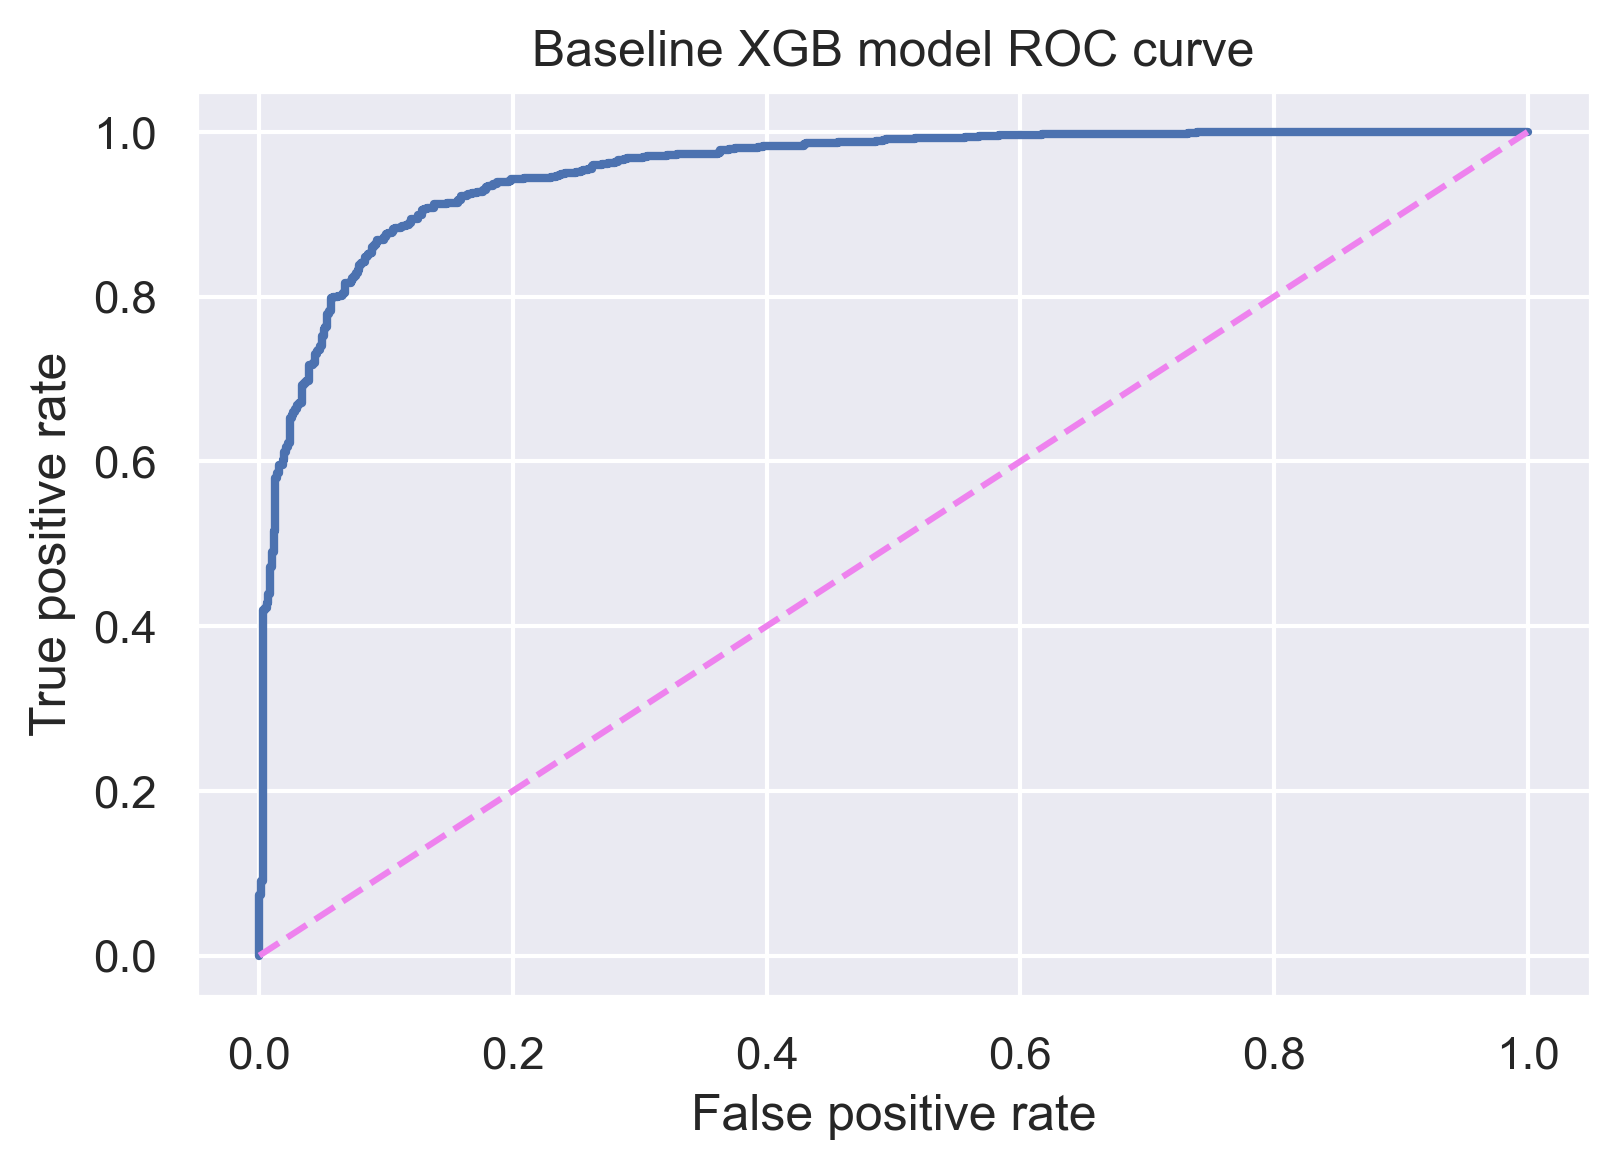

In [8]:
cu.plot_roc_curve(model, train_df, best_feats, title='Baseline XGB model')

## Incorporating features based on error 

### Error columns based on data from the mission 

In [141]:
raw_data_with_err = pd.read_csv('data/kepler_data_with_err.csv', index_col = 0)

In [142]:
err_cols = list(raw_data_with_err.columns)
err_cols = [col for col in err_cols if '_err' in col]

In [143]:
err_df = raw_data_with_err[['koi_name']+err_cols]
err_df

,koi_name,period_err1,period_err2,impact_parameter_err1,impact_parameter_err2,transit_duration_err1,transit_duration_err2,transit_depth_err1,transit_depth_err2,radius_err1,radius_err2,stellar_eff_temp_err1,stellar_eff_temp_err2,stellar_surf_grav_err1,stellar_surf_grav_err2,stellar_metal_err1,stellar_metal_err2,stellar_radius_err1,stellar_radius_err2,stellar_mass_err1,stellar_mass_err2
rowid,,,,,,,,,,,,,,,,,,,,,
1,K00752.01,2.780000e-05,-2.780000e-05,0.318,-0.146,0.08190,-0.08190,19.5,-19.5,0.26,-0.15,81.0,-81.0,0.064,-0.096,0.15,-0.15,0.105,-0.061,0.052,-0.046
2,K00752.02,2.480000e-04,-2.480000e-04,0.059,-0.443,0.11600,-0.11600,35.5,-35.5,0.32,-0.19,81.0,-81.0,0.064,-0.096,0.15,-0.15,0.105,-0.061,0.052,-0.046
3,K00753.01,1.490000e-05,-1.490000e-05,5.126,-0.077,0.03410,-0.03410,171.0,-171.0,3.92,-1.31,158.0,-176.0,0.044,-0.176,0.30,-0.30,0.233,-0.078,0.110,-0.121
4,K00754.01,2.630000e-07,-2.630000e-07,0.115,-0.092,0.00537,-0.00537,12.8,-12.8,8.50,-2.83,157.0,-174.0,0.053,-0.168,0.30,-0.30,0.201,-0.067,0.093,-0.077
5,K00755.01,3.760000e-06,-3.760000e-06,0.235,-0.478,0.04200,-0.04200,16.9,-16.9,0.88,-0.35,169.0,-211.0,0.070,-0.210,0.25,-0.30,0.334,-0.133,0.151,-0.136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,K07985.01,1.160000e-07,-1.160000e-07,0.051,-0.049,0.01740,-0.01740,4.6,-4.6,7.70,-2.57,139.0,-166.0,0.035,-0.196,0.20,-0.30,0.237,-0.079,0.084,-0.115
9561,K07986.01,1.780000e-05,-1.780000e-05,0.423,-0.043,0.22900,-0.22900,5.4,-5.4,0.24,-0.08,165.0,-220.0,0.056,-0.224,0.25,-0.30,0.341,-0.114,0.151,-0.135
9562,K07987.01,2.430000e-06,-2.430000e-06,0.309,-0.147,0.16200,-0.16200,14.7,-14.7,0.36,-0.11,193.0,-236.0,0.056,-0.224,0.25,-0.35,0.341,-0.114,0.146,-0.162


In [144]:
data_with_err = data.merge(err_df, how='left', on = 'koi_name')\
                    .dropna(axis=0, subset = err_cols)

In [145]:
cols_with_errs = [col[:-5] for col in err_cols[::2]]
for col in cols_with_errs:
    data_with_err[col + '_err_size'] = data_with_err[col + '_err1']-data_with_err[col + '_err2']
    data_with_err[col + '_err_proportion'] = data_with_err[col + '_err_size']/data_with_err[col]

In [146]:
data_with_err

,id,koi_name,kepler_name,planet_status,data_disposition,period,impact_parameter,transit_duration,transit_depth,radius,sma,inclination,eq_temp,mse_stat,mme_stat,signal_to_noise,num_transits,oedc_stat,stellar_eff_temp,stellar_surf_grav,stellar_metal,stellar_radius,stellar_mass,ra,dec,disposition_num,period_err1,period_err2,impact_parameter_err1,impact_parameter_err2,transit_duration_err1,transit_duration_err2,transit_depth_err1,transit_depth_err2,radius_err1,radius_err2,stellar_eff_temp_err1,stellar_eff_temp_err2,stellar_surf_grav_err1,stellar_surf_grav_err2,stellar_metal_err1,stellar_metal_err2,stellar_radius_err1,stellar_radius_err2,stellar_mass_err1,stellar_mass_err2,period_err_size,period_err_proportion,impact_parameter_err_size,impact_parameter_err_proportion,transit_duration_err_size,transit_duration_err_proportion,transit_depth_err_size,transit_depth_err_proportion,radius_err_size,radius_err_proportion,stellar_eff_temp_err_size,stellar_eff_temp_err_proportion,stellar_surf_grav_err_size,stellar_surf_grav_err_proportion,stellar_metal_err_size,stellar_metal_err_proportion,stellar_radius_err_size,stellar_radius_err_proportion,stellar_mass_err_size,stellar_mass_err_proportion
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,9.488036,0.146,2.95750,616.0,2.26,0.0853,89.66,793.0,5.135849,28.470820,35.8,142.0,0.6864,5455.0,4.467,0.14,0.927,0.919,291.93423,48.141651,1,2.780000e-05,-2.780000e-05,0.318,-0.146,0.08190,-0.08190,19.5,-19.5,0.26,-0.15,81.0,-81.0,0.064,-0.096,0.15,-0.15,0.105,-0.061,0.052,-0.046,5.560000e-05,5.860012e-06,0.464,3.178082,0.16380,0.055385,39.0,0.063312,0.41,0.181416,162.0,0.029698,0.160,0.035818,0.30,2.142857,0.166,0.179072,0.098,0.106638
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,54.418383,0.586,4.50700,875.0,2.83,0.2734,89.57,443.0,7.027669,20.109507,25.8,25.0,0.0023,5455.0,4.467,0.14,0.927,0.919,291.93423,48.141651,1,2.480000e-04,-2.480000e-04,0.059,-0.443,0.11600,-0.11600,35.5,-35.5,0.32,-0.19,81.0,-81.0,0.064,-0.096,0.15,-0.15,0.105,-0.061,0.052,-0.046,4.960000e-04,9.114567e-06,0.502,0.856655,0.23200,0.051475,71.0,0.081143,0.51,0.180212,162.0,0.029698,0.160,0.035818,0.30,2.142857,0.166,0.179072,0.098,0.106638
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,19.899140,0.969,1.78220,10800.0,14.60,0.1419,88.96,638.0,37.159767,187.449100,76.3,56.0,0.6624,5853.0,4.544,-0.18,0.868,0.961,297.00482,48.134129,1,1.490000e-05,-1.490000e-05,5.126,-0.077,0.03410,-0.03410,171.0,-171.0,3.92,-1.31,158.0,-176.0,0.044,-0.176,0.30,-0.30,0.233,-0.078,0.110,-0.121,2.980000e-05,1.497552e-06,5.203,5.369453,0.06820,0.038267,342.0,0.031667,5.23,0.358219,334.0,0.057065,0.220,0.048415,0.60,-3.333333,0.311,0.358295,0.231,0.240375
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,1.736952,1.276,2.40641,8080.0,33.46,0.0267,67.09,1395.0,39.066550,541.895100,505.6,621.0,0.0000,5805.0,4.564,-0.52,0.791,0.836,285.53461,48.285210,0,2.630000e-07,-2.630000e-07,0.115,-0.092,0.00537,-0.00537,12.8,-12.8,8.50,-2.83,157.0,-174.0,0.053,-0.168,0.30,-0.30,0.201,-0.067,0.093,-0.077,5.260000e-07,3.028292e-07,0.207,0.162226,0.01074,0.004463,25.6,0.003168,11.33,0.338613,331.0,0.057020,0.221,0.048422,0.60,-1.153846,0.268,0.338812,0.170,0.203349
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,2.525592,0.701,1.65450,603.0,2.75,0.0374,85.41,1406.0,4.749945,33.191900,40.9,515.0,0.3090,6031.0,4.438,0.07,1.046,1.095,288.75488,48.226200,1,3.760000e-06,-3.760000e-06,0.235,-0.478,0.04200,-0.04200,16.9,-16.9,0.88,-0.35,169.0,-211.0,0.070,-0.210,0.25,-0.30,0.334,-0.133,0.151,-0.136,7.520000e-06,2.977520e-06,0.713,1.017118,0.08400,0.050771,33.8,0.056053,1.23,0.447273,380.0,0.063008,0.280,0.063091,0.55,7.857143,0.467,0.446463,0.287,0.262100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7984,10090151,K07985.01,NaN,FALSE POSIT

In [126]:
train_df, test_df = train_test_split(data_with_err, test_size = .25)

In [127]:
err_sizes = [col for col in list(data_with_err.columns) if '_err_size' in col]
err_proportions = [col for col in list(data_with_err.columns) if '_err_proportion' in col]

In [128]:
cu.xgb_test_model_CV(model, train_df, best_feats)

Mean validation accuracy: 0.878
Mean validation recall  : 0.920
Mean validation precision: 0.860
Mean validation f1  : 0.889
Mean validation roc_auc: 0.943


In [129]:
cu.xgb_test_model_CV(model, train_df, best_feats+err_sizes)

Mean validation accuracy: 0.887
Mean validation recall  : 0.916
Mean validation precision: 0.877
Mean validation f1  : 0.896
Mean validation roc_auc: 0.954


In [136]:
cu.xgb_test_model_CV(model, train_df, best_feats+err_proportions)

Mean validation accuracy: 0.887
Mean validation recall  : 0.910
Mean validation precision: 0.881
Mean validation f1  : 0.895
Mean validation roc_auc: 0.955


In [20]:
cu.xgb_test_model_CV(model, train_df, best_feats+err_sizes+err_proportions)

Mean validation accuracy: 0.888
Mean validation recall  : 0.913
Mean validation precision: 0.877
Mean validation f1  : 0.894
Mean validation roc_auc: 0.953


While it didn't technically perform the best in recall, the features + error proportions did better than just the features on a few other metrics, and because it may help with interpretibility I will go with that, pending the next subsection about testing columns derived on the averages of the target categories

### Error columns based on data itself

In [131]:
def xgb_test_model_CV2(classifier, df, features, target='disposition_num', preprocessor = None):
    """
    Alternate 
    """
    accuracies = []
    recalls = []
    precisions = []
    f1s =[]
    roc_aucs= []

    kf = KFold(n_splits=4, shuffle=True)
    for train_index, val_index in kf.split(df):
        train_df, val_df = df.iloc[train_index].copy(), df.iloc[val_index].copy()
        
        feature_means = train_df.groupby('disposition_num')[features].mean()
        feature_stds = train_df.groupby('disposition_num')[features].std()
        
        new_features = []
        for feature in features:
            train_df[feature+'_0mean_stds_away'] = (train_df[feature] - feature_means.iloc[0][feature])/feature_stds.iloc[0][feature]
            train_df[feature+'_1mean_stds_away'] = (train_df[feature] - feature_means.iloc[1][feature])/feature_stds.iloc[1][feature]
            val_df[feature+'_0mean_stds_away'] = (val_df[feature] - feature_means.iloc[0][feature])/feature_stds.iloc[0][feature]
            val_df[feature+'_1mean_stds_away'] = (val_df[feature] - feature_means.iloc[1][feature])/feature_stds.iloc[1][feature]
            new_features.extend([feature,feature+'_0mean_stds_away', feature + '_1mean_stds_away'])
            #new_features.extend([feature,feature + '_1mean_stds_away'])
    
        X_train = train_df[new_features]
        X_val = val_df[new_features]
        y_train = train_df[target]
        y_val = val_df[target]
        #return X_train
        eval_set=[(X_train,y_train),(X_val,y_val)]
        fit_model = classifier.fit(
                        X_train, y_train,
                        eval_set=eval_set,
                        eval_metric='error',
                        early_stopping_rounds=50,
                        verbose=False
                        )
        y_pred = classifier.predict(X_val)

        accuracies.append(accuracy_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        precisions.append(precision_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        roc_aucs.append(roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1]))
    print('Mean validation accuracy: {:.3f}'.format(np.mean(accuracies)))
    print('Mean validation recall  : {:.3f}'.format(np.mean(recalls)))
    print('Mean validation precision: {:.3f}'.format(np.mean(precisions)))
    print('Mean validation f1  : {:.3f}'.format(np.mean(f1s)))
    print('Mean validation roc_auc: {:.3f}'.format(np.mean(roc_aucs)))

In [132]:
xgb_test_model_CV2(model, train_df, best_feats)

Mean validation accuracy: 0.881
Mean validation recall  : 0.918
Mean validation precision: 0.866
Mean validation f1  : 0.891
Mean validation roc_auc: 0.946


In [133]:
cu.xgb_test_model_CV(model, train_df, best_feats)

Mean validation accuracy: 0.875
Mean validation recall  : 0.914
Mean validation precision: 0.860
Mean validation f1  : 0.886
Mean validation roc_auc: 0.943


Performance difference is relatively minor and not really worth the complexity of 2 extra columns for each feature and the potential for data leakage.

## Plotting feature importances

In [186]:
def plot_feature_importance(model, features, formatted_features, title):
    df = pd.DataFrame()
    df['importance'] = model.feature_importances_
    df['feature'] = features
    df['formatted_feature'] = formatted_features
    df.sort_values(by='importance',ascending=False,inplace=True)
    plt.figure(dpi=200, figsize=(15,10))
    sns.barplot(data = df, x='importance', y='formatted_feature', color='SteelBlue')
    plt.title(title, fontsize=24)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
    return df

## Final modeling


In [148]:
final_features = best_feats+err_proportions

In [149]:
final_features

['period',
 'impact_parameter',
 'transit_duration',
 'transit_depth',
 'radius',
 'inclination',
 'mse_stat',
 'mme_stat',
 'signal_to_noise',
 'num_transits',
 'oedc_stat',
 'stellar_eff_temp',
 'stellar_surf_grav',
 'stellar_metal',
 'stellar_radius',
 'stellar_mass',
 'period_err_proportion',
 'impact_parameter_err_proportion',
 'transit_duration_err_proportion',
 'transit_depth_err_proportion',
 'radius_err_proportion',
 'stellar_eff_temp_err_proportion',
 'stellar_surf_grav_err_proportion',
 'stellar_metal_err_proportion',
 'stellar_radius_err_proportion',
 'stellar_mass_err_proportion']

In [156]:
X = data_with_err[final_features]
y = data_with_err['disposition_num']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .25)

final_model = xgb.XGBClassifier(n_estimators=50000,max_depth = 6,eta = 0.025,objective='binary:logistic',
                          min_child_weight=1,subsample = 1,colsample_bytree=.8,use_label_encoder=False)

eval_set=[(X_test, y_test)]
final_model.fit(X_train, y_train, eval_set=eval_set, eval_metric='error', early_stopping_rounds=50, verbose=False);

In [157]:
y_pred = final_model.predict(X_test)

In [158]:
print(classification_report(y_test,y_pred, target_names=['Not a Candidate', 'Candidate']))

                 precision    recall  f1-score   support

Not a Candidate       0.90      0.87      0.89       958
      Candidate       0.88      0.91      0.89       992

       accuracy                           0.89      1950
      macro avg       0.89      0.89      0.89      1950
   weighted avg       0.89      0.89      0.89      1950



<Figure size 900x600 with 0 Axes>

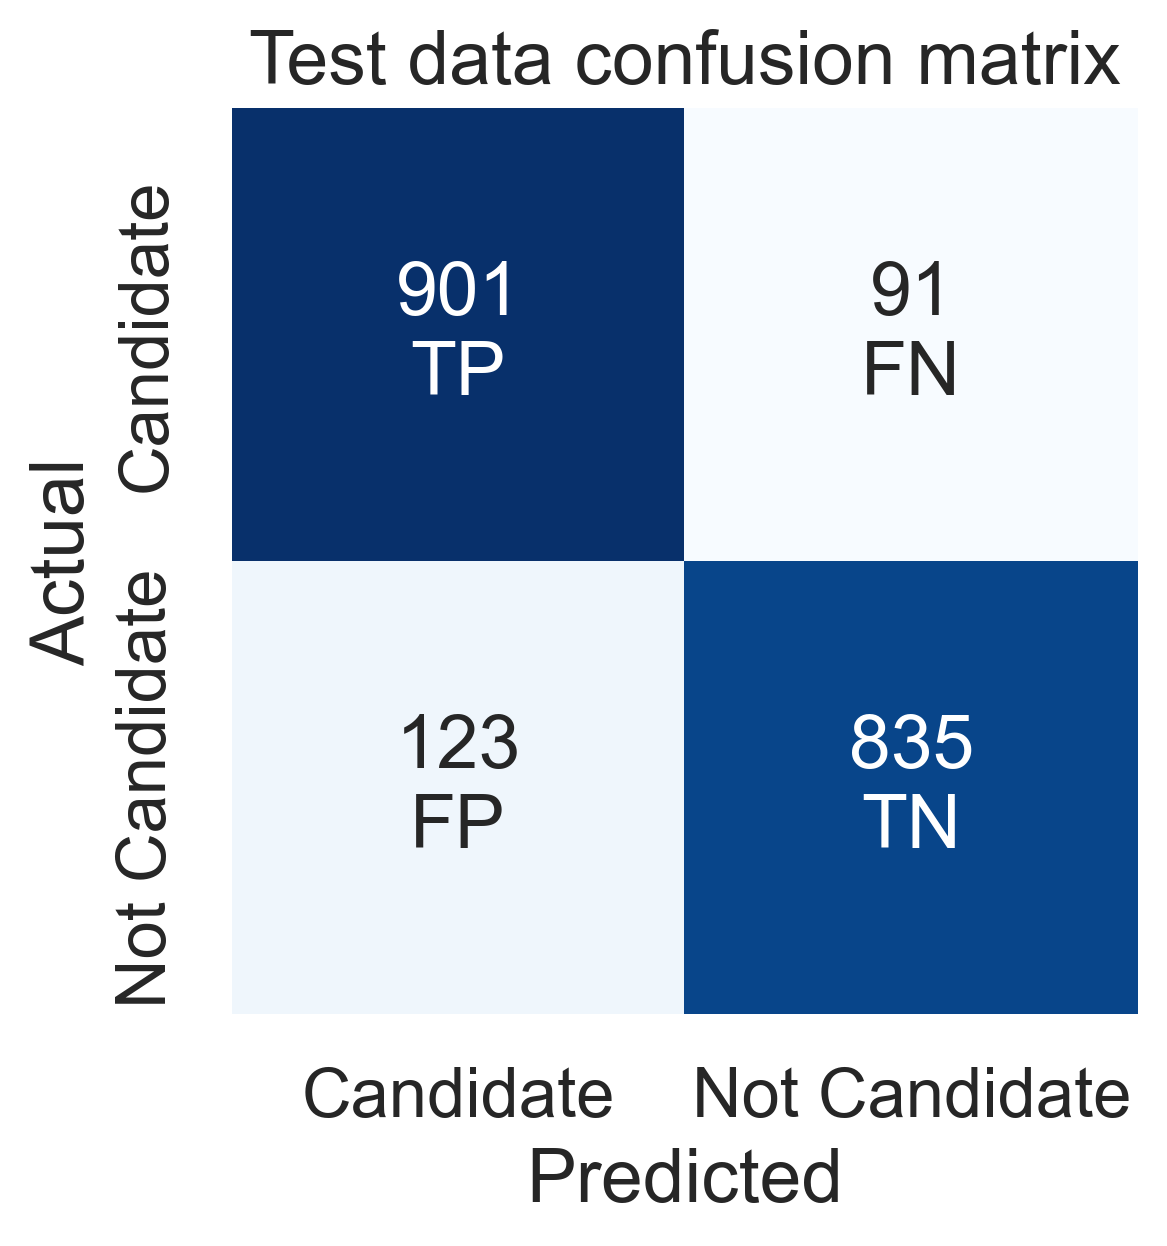

In [196]:
plt.figure(dpi=150)
cm = confusion_matrix(y_test, y_pred)
cm=np.rot90(cm, k=2)
plt.figure(dpi=150)
annot = [[1,1],[1,1]]
annot[0][0] = str(cm[0,0])+'\nTP'
annot[0][1] = str(cm[0,1])+'\nFN'
annot[1][0] = str(cm[1,0])+'\nFP'
annot[1][1] = str(cm[1,1])+'\nTN'
sns.heatmap(cm, cmap = plt.cm.Blues, annot=annot, fmt = '', square=True,cbar = False,
           xticklabels=['Candidate','Not Candidate'],
           yticklabels=['Candidate','Not Candidate'])
plt.yticks(va='center')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test data confusion matrix')
plt.show()

ROC AUC score =  0.9539846959391205


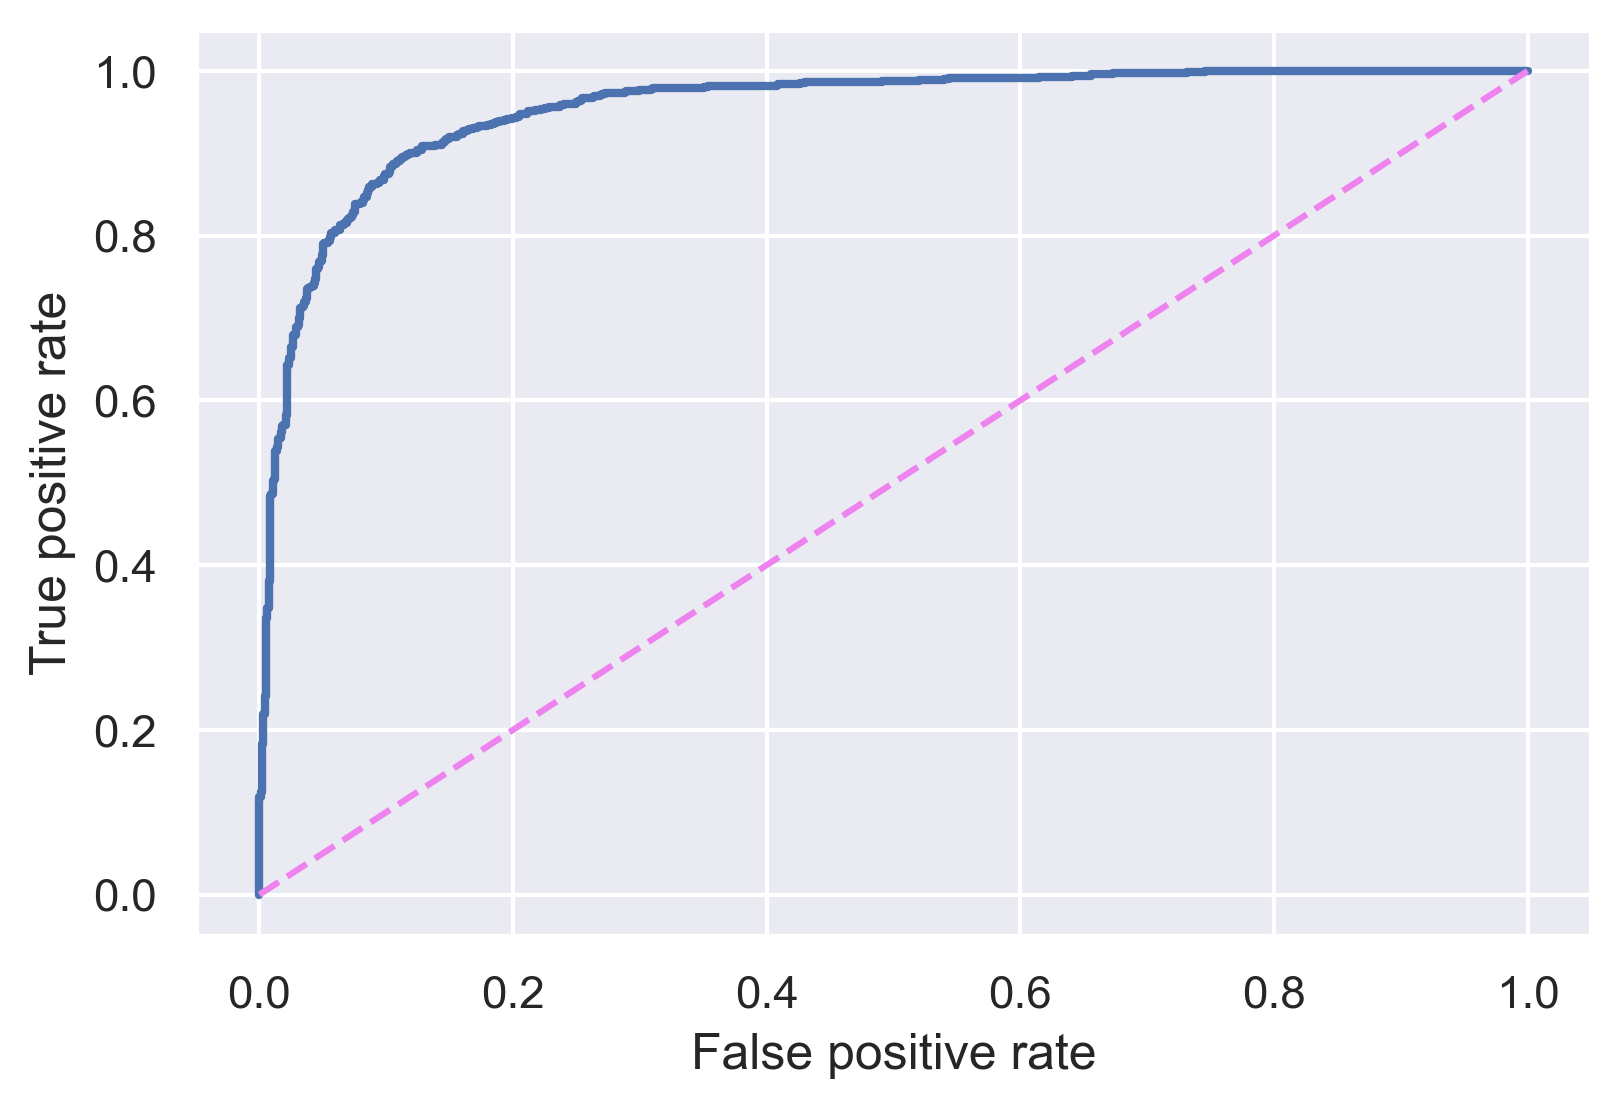

In [161]:
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test)[:,1])

plt.figure(dpi=150)
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
#plt.title(title +' ROC curve')
print("ROC AUC score = ", roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1]))
plt.show()

In [183]:
plot_feature_importance(final_model, final_features, title='Planetary and transit properties are generally the most important features');

TypeError: plot_feature_importance() missing 1 required positional argument: 'formatted_features'

In [175]:
final_features_formatted=['Period',
 'Impact Parameter',
 'Transit Duration',
 'Transit Depth',
 'Radius',
 'Inclination',
 'MSE Statistic',
 'MME Statistic',
 'Signal to Noise',
 'Number of transits',
 'OEDC Statistic',
 'Stellar Temperature',
 'Stellar Surface Gravity',
 'Stellar Metallicity',
 'Stellar Radius',
 'Stellar Mass',
 'Period Error Proportion',
 'Impact Parameter Error Proportion',
 'Transit Duration Error Proportion',
 'Transit Depth Error Proportion',
 'Radius Error Proportion',
 'Stellar Temperature Error Proportion',
 'Stellar Surface Gravity Error Proportion',
 'Stellar Metallicity Error Proportion',
 'Stellar Radius Error Proportion',
 'Stellar Mass Error Proportion']

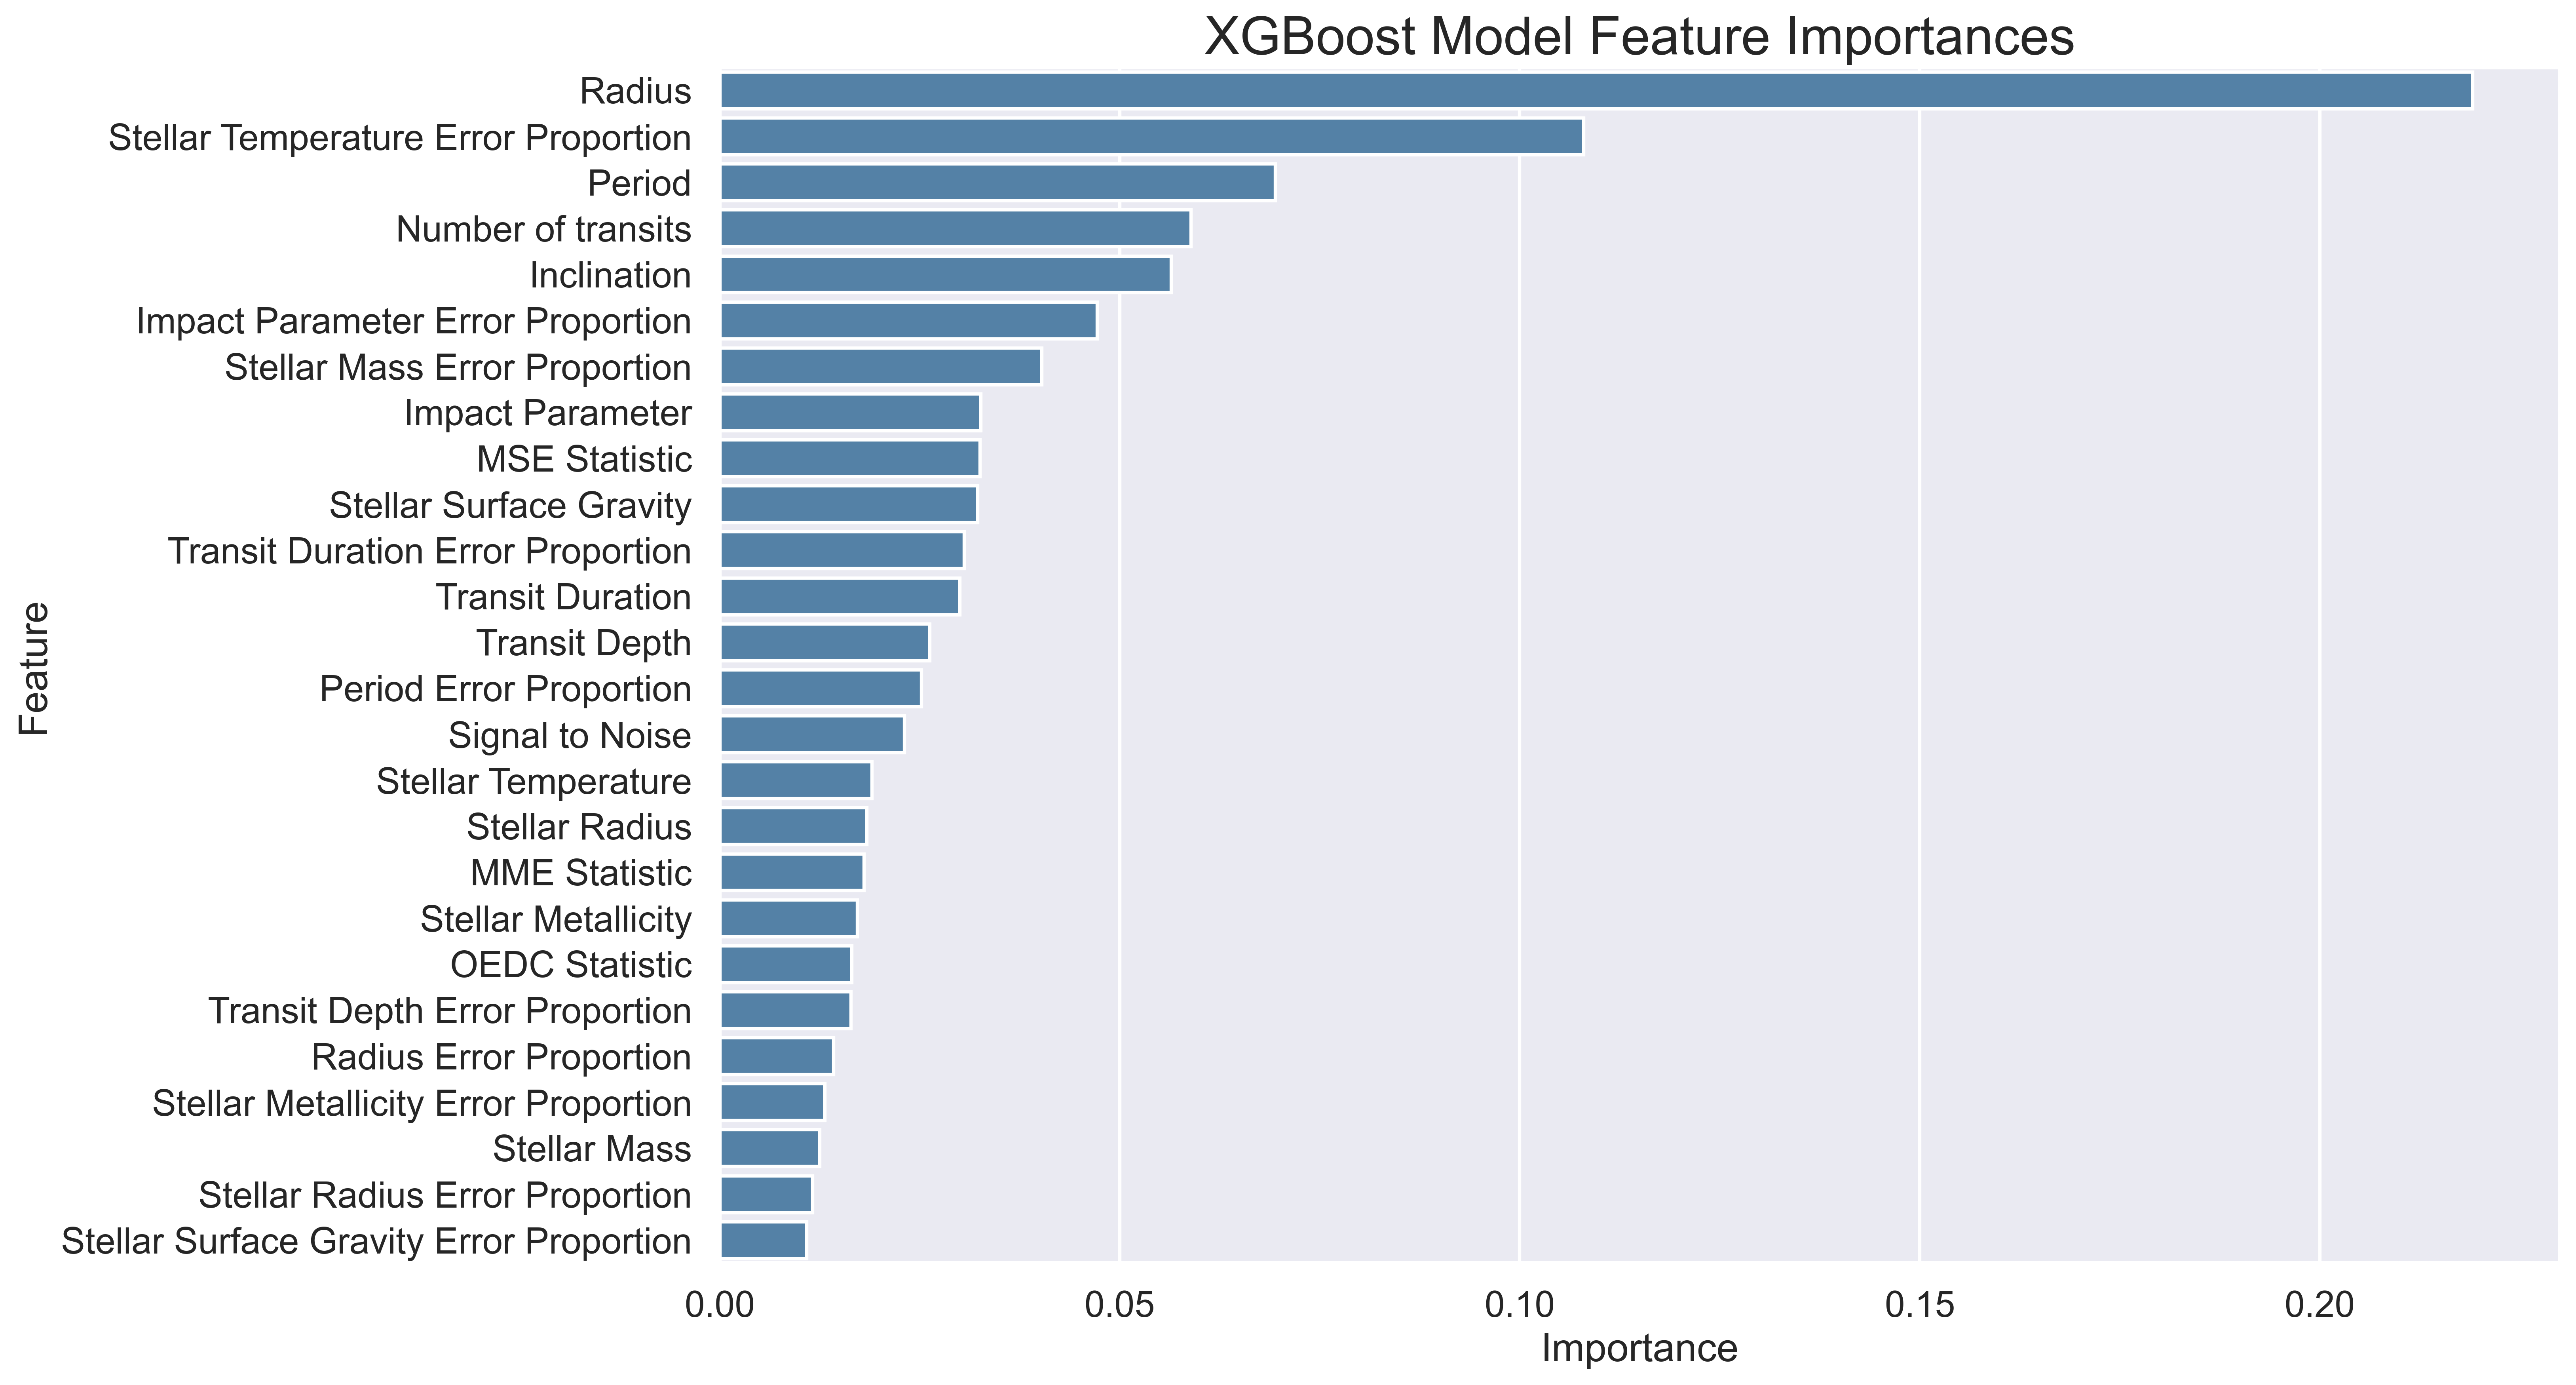

,importance,feature,formatted_feature
4,0.219097,radius,Radius
21,0.107989,stellar_eff_temp_err_proportion,Stellar Temperature Error Proportion
0,0.069462,period,Period
9,0.058937,num_transits,Number of transits
5,0.056447,inclination,Inclination
17,0.047167,impact_parameter_err_proportion,Impact Parameter Error Proportion
25,0.040250,stellar_mass_err_proportion,Stellar Mass Error Proportion
1,0.032620,impact_parameter,Impact Parameter
6,0.032561,mse_stat,MSE Statistic
12,0.032262,stellar_surf_grav,Stellar Surface Gravity


In [188]:
plot_feature_importance(final_model, final_features, final_features_formatted, 'XGBoost Model Feature Importances')

In [178]:
data_with_err_tab = data_with_err.copy()
data_with_err_tab['candidate_probability'] = final_model.predict_proba(data_with_err_tab[final_features])[:,1]

In [180]:
data_with_err_tab.to_csv('data/tableau_data.csv')

In [189]:
accuracy_score(y_test,y_pred)

0.8902564102564102

In [190]:
precision_score(y_test,y_pred)

0.8798828125

In [191]:
f1_score(y_test, y_pred)

0.8938492063492064

In [193]:
data_with_err_tab.sort_values('radius')

,id,koi_name,kepler_name,planet_status,data_disposition,period,impact_parameter,transit_duration,transit_depth,radius,sma,inclination,eq_temp,mse_stat,mme_stat,signal_to_noise,num_transits,oedc_stat,stellar_eff_temp,stellar_surf_grav,stellar_metal,stellar_radius,stellar_mass,ra,dec,disposition_num,period_err1,period_err2,impact_parameter_err1,impact_parameter_err2,transit_duration_err1,transit_duration_err2,transit_depth_err1,transit_depth_err2,radius_err1,radius_err2,stellar_eff_temp_err1,stellar_eff_temp_err2,stellar_surf_grav_err1,stellar_surf_grav_err2,stellar_metal_err1,stellar_metal_err2,stellar_radius_err1,stellar_radius_err2,stellar_mass_err1,stellar_mass_err2,period_err_size,period_err_proportion,impact_parameter_err_size,impact_parameter_err_proportion,transit_duration_err_size,transit_duration_err_proportion,transit_depth_err_size,transit_depth_err_proportion,radius_err_size,radius_err_proportion,stellar_eff_temp_err_size,stellar_eff_temp_err_proportion,stellar_surf_grav_err_size,stellar_surf_grav_err_proportion,stellar_metal_err_size,stellar_metal_err_proportion,stellar_radius_err_size,stellar_radius_err_proportion,stellar_mass_err_size,stellar_mass_err_proportion,candidate_probability
4190,3330684,K04533.01,NaN,FALSE POSITIVE,FALSE POSITIVE,1.261328,0.289,1.2440,110.0,0.14,0.0108,87.80,447.0,4.166590,9.864657,9.9,1059.0,0.9469,2900.0,5.224,0.00,0.132,0.107,288.11703,38.437733,0,0.000007,-0.000007,0.177,-0.289,0.1170,-0.1170,10.5,-10.5,0.00,0.00,0.0,0.0,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000013,0.000011,0.466,1.612457,0.2340,0.188103,21.0,0.190909,0.00,0.000000,0.0,0.000000,0.000,0.000000,0.00,NaN,0.000,0.000000,0.000,0.000000,0.189293
7655,10340212,K08003.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.933749,0.457,4.6370,226.0,0.18,0.0085,73.02,433.0,3.464341,8.501308,9.3,1409.0,0.1630,2661.0,5.283,0.00,0.116,0.094,292.11115,47.452293,0,0.000015,-0.000015,0.028,-0.457,0.6700,-0.6700,40.6,-40.6,0.00,0.00,0.0,0.0,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000029,0.000031,0.485,1.061269,1.3400,0.288980,81.2,0.359292,0.00,0.000000,0.0,0.000000,0.000,0.000000,0.00,NaN,0.000,0.000000,0.000,0.000000,0.041630
7273,5513833,K06591.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.755101,0.523,3.3710,76.7,0.19,0.0092,71.50,680.0,3.565113,9.460423,13.4,1381.0,0.8368,3256.0,5.071,0.00,0.207,0.184,284.33002,40.736401,0,0.000006,-0.000006,0.004,-0.491,0.2380,-0.2380,7.1,-7.1,0.02,-0.02,39.0,-29.0,0.044,-0.044,0.10,-0.10,0.032,-0.023,0.036,-0.024,0.000012,0.000016,0.495,0.946463,0.4760,0.141204,14.2,0.185137,0.04,0.210526,68.0,0.020885,0.088,0.017354,0.20,inf,0.055,0.265700,0.060,0.326087,0.063333
7116,6423922,K06705.01,NaN,CANDIDATE,CANDIDATE,0.995141,0.998,5.5880,102.0,0.22,0.0091,16.81,509.0,3.661286,12.779973,17.6,1014.0,0.6741,3325.0,5.364,-0.94,0.109,0.101,284.23990,41.819042,1,0.000010,-0.000010,0.351,-0.020,0.5130,-0.5130,7.3,-7.3,0.14,-0.01,117.0,-25.0,0.012,-0.228,0.35,-0.20,0.073,-0.002,0.064,-0.002,0.000020,0.000020,0.371,0.371743,1.0260,0.183608,14.6,0.143137,0.15,0.681818,142.0,0.042707,0.240,0.044743,0.55,-0.585106,0.075,0.688073,0.066,0.653465,0.476910
2469,8227661,K02826.01,NaN,FALSE POSITIVE,FALSE POSITIVE,1.853739,0.551,1.8160,349.0,0.23,0.0134,85.29,345.0,3.929198,16.466364,18.0,516.0,0.3007,2661.0,5.283,0.00,0.116,0.094,289.84772,44.185783,0,0.000012,-0.000012,0.398,-0.337,0.1420,-0.1420,24.4,-24.4,0.00,0.00,0.0,0.0,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000024,0.000013,0.735,1.333938,0.2840,0.156388,48.8,0.139828,0.00,0.000000,0.0,0.000000,0.000,0.000000,0.00,NaN,0.000,0.000000,0.000,0.000000,0.144558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,7918217,K01770.01,NaN,FALSE POSITIVE,FALSE POSITIVE,63.935496,1.200,13.3210,1250.0,2637.60,0.3716,84.55,2590.0,70.888450,92.80495

In [195]:
len(data_with_err_tab[data_with_err_tab['radius']>10])

2311